<a href="https://colab.research.google.com/github/rjanovicci/yolo_transfer_learning/blob/master/YOLO_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics pycocotools scikit-learn pyyaml

import os
import requests
import zipfile
import shutil
import random
import cv2
import yaml
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/CustomDataset'
download_dir = os.path.join(base_dir, 'download')
images_download_dir = os.path.join(download_dir, 'images')
labels_download_dir = os.path.join(download_dir, 'labels')
os.makedirs(images_download_dir, exist_ok=True)
os.makedirs(labels_download_dir, exist_ok=True)

In [ ]:
classes_of_interest = ['handbag', 'tie']
num_images_per_class = 100

In [ ]:
annotations_zip_path = os.path.join(base_dir, 'annotations_trainval2017.zip')
annotations_dir = os.path.join(base_dir, 'annotations')
if not os.path.exists(annotations_zip_path):
    print("Baixando anotações do COCO...")
    annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
    response = requests.get(annotations_url)
    with open(annotations_zip_path, 'wb') as f:
        f.write(response.content)

if not os.path.exists(annotations_dir):
    print("Extraindo anotações...")
    with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
        zip_ref.extractall(base_dir)

In [ ]:
coco_ann_file = os.path.join(annotations_dir, 'instances_train2017.json')
coco = COCO(coco_ann_file)

loading annotations into memory...
Done (t=20.60s)
creating index...
index created!


In [ ]:
def download_coco_images(coco, class_name, num_images, images_save_dir, labels_save_dir):
    cat_ids = coco.getCatIds(catNms=[class_name])
    if len(cat_ids) == 0:
        print(f"Atenção: Categoria '{class_name}' não encontrada no COCO. Verifique o nome!")
        return
    img_ids = coco.getImgIds(catIds=cat_ids)
    if len(img_ids) < num_images:
        print(f"Para '{class_name}': solicitado {num_images} imagens, mas só foram encontradas {len(img_ids)}. Usando todas.")
        num_images = len(img_ids)
    img_ids = random.sample(img_ids, num_images)
    img_info_list = coco.loadImgs(img_ids)
    # Definir o índice da classe com base na ordem definida em classes_of_interest
    class_idx = classes_of_interest.index(class_name)

    for img_info in img_info_list:
        try:
            img_data = requests.get(img_info['coco_url']).content
        except Exception as e:
            print("Erro ao baixar imagem:", e)
            continue
        # Nome único para a imagem
        img_filename = f"{class_name}_{img_info['id']}.jpg"
        img_filepath = os.path.join(images_save_dir, img_filename)
        with open(img_filepath, 'wb') as f:
            f.write(img_data)

        img = cv2.imread(img_filepath)
        if img is None:
            print("Imagem não pôde ser lida:", img_filename)
            continue
        height, width, _ = img.shape

        # Obter anotações específicas para esta imagem e categoria
        ann_ids = coco.getAnnIds(imgIds=[img_info['id']], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        # Criar o arquivo de rótulo no formato YOLO: class x_center y_center width height (valores normalizados)
        label_filename = img_filename.replace('.jpg', '.txt')
        label_filepath = os.path.join(labels_save_dir, label_filename)
        with open(label_filepath, 'w') as f:
            for ann in anns:
                bbox = ann['bbox']  # COCO: [x, y, width, height]
                x_center = (bbox[0] + bbox[2] / 2) / width
                y_center = (bbox[1] + bbox[3] / 2) / height
                w_norm = bbox[2] / width
                h_norm = bbox[3] / height
                f.write(f"{class_idx} {x_center} {y_center} {w_norm} {h_norm}\n")

In [ ]:
for cls in classes_of_interest:
    print(f"Baixando imagens para a classe: {cls}")
    download_coco_images(coco, cls, num_images_per_class, images_download_dir, labels_download_dir)

Baixando imagens para a classe: handbag
Baixando imagens para a classe: tie


In [ ]:
train_images_dir = os.path.join(base_dir, 'images', 'train')
val_images_dir   = os.path.join(base_dir, 'images', 'val')
train_labels_dir = os.path.join(base_dir, 'labels', 'train')
val_labels_dir   = os.path.join(base_dir, 'labels', 'val')
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

all_images = [os.path.join(images_download_dir, f) for f in os.listdir(images_download_dir) if f.endswith('.jpg')]
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

def copy_image_and_label(img_path, dest_img_dir, dest_label_dir):
    filename = os.path.basename(img_path)
    label_filename = filename.replace('.jpg', '.txt')
    shutil.copy(img_path, os.path.join(dest_img_dir, filename))
    src_label_path = os.path.join(labels_download_dir, label_filename)
    if os.path.exists(src_label_path):
        shutil.copy(src_label_path, os.path.join(dest_label_dir, label_filename))

for img_path in train_imgs:
    copy_image_and_label(img_path, train_images_dir, train_labels_dir)

for img_path in val_imgs:
    copy_image_and_label(img_path, val_images_dir, val_labels_dir)

In [ ]:
dataset_yaml = {
    'train': train_images_dir,
    'val': val_images_dir,
    'nc': len(classes_of_interest),
    'names': classes_of_interest
}
yaml_path = os.path.join(base_dir, 'custom_dataset.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(dataset_yaml, f)

print("Preparação do dataset concluída!")
print("Arquivo YAML criado em:", yaml_path)

Preparação do dataset concluída!
Arquivo YAML criado em: /content/drive/MyDrive/CustomDataset/custom_dataset.yaml


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("yolo11n.pt")


100%|██████████| 5.35M/5.35M [00:00<00:00, 91.2MB/s]


In [ ]:
print("Iniciando treinamento...")
results = model.train(data=yaml_path, epochs=100, imgsz=640)

Iniciando treinamento...
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/CustomDataset/custom_dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/CustomDataset/labels/train... 347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 347/347 [00:10<00:00, 32.57it/s]


train: New cache created: /content/drive/MyDrive/CustomDataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/CustomDataset/labels/val... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:06<00:00, 14.44it/s]

val: New cache created: /content/drive/MyDrive/CustomDataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.45G      1.704      4.042      1.423         32        640: 100%|██████████| 22/22 [00:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        101        208    0.00225      0.333     0.0786     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.39G       1.87      3.698      1.463         37        640: 100%|██████████| 22/22 [00:10<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        101        208      0.002      0.294    0.00883    0.00413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.39G      1.992      3.619      1.513         26        640: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


                   all        101        208      0.558    0.00971     0.0109    0.00352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.36G      2.041        3.6      1.574         35        640: 100%|██████████| 22/22 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        101        208     0.0237     0.0243      0.013    0.00457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.36G      2.038      3.461      1.598         29        640: 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


                   all        101        208      0.155      0.087     0.0493     0.0226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.39G      2.017      3.348      1.597         44        640: 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        101        208      0.516     0.0874     0.0158    0.00626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.36G      2.102      3.386      1.683         30        640: 100%|██████████| 22/22 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        101        208      0.331      0.107      0.057     0.0193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.36G      1.971      3.179      1.557         31        640: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        101        208       0.23     0.0969     0.0551      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.38G      1.961       3.11       1.57         20        640: 100%|██████████| 22/22 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


                   all        101        208      0.148      0.179     0.0907     0.0366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.39G      1.979      2.954      1.625         35        640: 100%|██████████| 22/22 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


                   all        101        208      0.261      0.254      0.125     0.0565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.41G      1.965      2.969      1.531         18        640: 100%|██████████| 22/22 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


                   all        101        208      0.203      0.159      0.103     0.0457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.38G      2.026      2.922       1.58         34        640: 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


                   all        101        208      0.349      0.095     0.0997     0.0453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.38G      1.973      2.768      1.543         33        640: 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        101        208       0.22      0.171       0.13     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.38G       1.86      2.589       1.53         18        640: 100%|██████████| 22/22 [00:07<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


                   all        101        208      0.231      0.221       0.13     0.0664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.39G      1.926       2.64      1.521         22        640: 100%|██████████| 22/22 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        101        208      0.166      0.154     0.0744     0.0429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.38G      1.888       2.62      1.514         32        640: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        101        208      0.346      0.208      0.167     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.36G      1.821      2.534      1.482         25        640: 100%|██████████| 22/22 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        101        208      0.311      0.226      0.174     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.39G      1.785      2.412      1.478         30        640: 100%|██████████| 22/22 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


                   all        101        208      0.264      0.232      0.162     0.0779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.39G       1.75        2.4      1.442         19        640: 100%|██████████| 22/22 [00:08<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        101        208      0.375      0.217      0.187     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.38G      1.827      2.383       1.47         41        640: 100%|██████████| 22/22 [00:08<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


                   all        101        208      0.555      0.207      0.227      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.36G      1.741      2.271      1.366         27        640: 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


                   all        101        208      0.355      0.274      0.217      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.38G      1.715      2.275       1.43         30        640: 100%|██████████| 22/22 [00:07<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        101        208      0.317       0.27       0.22      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.39G      1.706       2.19      1.403         35        640: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        101        208      0.334       0.25      0.218       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.39G      1.763      2.234      1.421         57        640: 100%|██████████| 22/22 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        101        208      0.553      0.217      0.229      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.39G      1.691      2.103      1.395         38        640: 100%|██████████| 22/22 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        101        208       0.43      0.263      0.256      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.36G        1.6      2.072      1.334         24        640: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        101        208      0.357      0.277      0.233      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.41G      1.603      1.953       1.33         32        640: 100%|██████████| 22/22 [00:08<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        101        208      0.435       0.27      0.267      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.38G      1.643       2.01      1.375         33        640: 100%|██████████| 22/22 [00:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        101        208      0.292      0.261       0.22      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.39G      1.551      1.912      1.302         49        640: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        101        208      0.457      0.279      0.276      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.39G      1.603      1.948      1.295         24        640: 100%|██████████| 22/22 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        101        208      0.526      0.294       0.29      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.38G      1.562      1.911      1.304         19        640: 100%|██████████| 22/22 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        101        208      0.506      0.311      0.318      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.38G      1.563      1.969        1.3         44        640: 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        101        208       0.45      0.318      0.303      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.39G      1.581      1.948      1.305         36        640: 100%|██████████| 22/22 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        101        208      0.488      0.308      0.283      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.39G       1.54      1.878       1.26         27        640: 100%|██████████| 22/22 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        101        208      0.532      0.299      0.319      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.39G       1.55      1.778      1.302         35        640: 100%|██████████| 22/22 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        101        208      0.532      0.308      0.343       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.39G      1.545      1.768      1.286         26        640: 100%|██████████| 22/22 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        101        208      0.559      0.356      0.333      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.39G      1.461       1.76      1.259         21        640: 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        101        208      0.518      0.369      0.358      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.38G      1.451      1.699       1.28         47        640: 100%|██████████| 22/22 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        101        208      0.507      0.396      0.353      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.36G      1.529      1.726      1.254         46        640: 100%|██████████| 22/22 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        101        208      0.605      0.384      0.375      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.39G      1.429      1.545      1.217         19        640: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


                   all        101        208      0.618      0.327      0.356      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.38G      1.408      1.592      1.218         36        640: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


                   all        101        208      0.516      0.395      0.391      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.41G      1.381      1.477       1.22         30        640: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        101        208      0.587      0.394        0.4      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.38G      1.436       1.55      1.204         29        640: 100%|██████████| 22/22 [00:08<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


                   all        101        208      0.662       0.37      0.414      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.39G      1.399      1.539      1.214         34        640: 100%|██████████| 22/22 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        101        208      0.614      0.414      0.425      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.41G      1.367      1.474      1.199         27        640: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        101        208      0.706      0.339      0.405      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.39G       1.37      1.494      1.177         28        640: 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        101        208      0.532      0.356      0.362      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.36G      1.384      1.506       1.16         44        640: 100%|██████████| 22/22 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        101        208      0.648      0.322      0.354      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.39G      1.364      1.394      1.176         30        640: 100%|██████████| 22/22 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        101        208      0.615      0.317      0.363      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.38G      1.328      1.428      1.174         34        640: 100%|██████████| 22/22 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        101        208      0.619      0.328       0.39      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.38G      1.375      1.421      1.171         39        640: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        101        208      0.695      0.332      0.398      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G      1.311      1.338      1.158         44        640: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        101        208      0.617      0.352      0.399      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.38G      1.351      1.332      1.152         46        640: 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        101        208      0.622      0.355      0.395      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.39G      1.296       1.36       1.16         34        640: 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        101        208      0.678      0.369      0.405      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.39G      1.323       1.42      1.163         24        640: 100%|██████████| 22/22 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


                   all        101        208      0.649      0.413      0.435      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.38G        1.3      1.326      1.135         41        640: 100%|██████████| 22/22 [00:08<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        101        208      0.704      0.404      0.437      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.38G      1.295      1.317      1.162         32        640: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        101        208      0.533      0.414      0.406      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.39G      1.254      1.266      1.112         29        640: 100%|██████████| 22/22 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        101        208      0.571      0.407       0.42      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.34G      1.315      1.319       1.16         33        640: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all        101        208      0.637      0.375      0.425      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.35G      1.231      1.232      1.127         37        640: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


                   all        101        208      0.763      0.379      0.448      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.38G      1.313      1.329      1.146         34        640: 100%|██████████| 22/22 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        101        208      0.616      0.457       0.47      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.39G      1.234      1.204      1.119         35        640: 100%|██████████| 22/22 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all        101        208      0.765      0.438       0.47      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.39G       1.25      1.222      1.104         28        640: 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


                   all        101        208      0.736      0.423      0.459      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.38G      1.182      1.147      1.085         35        640: 100%|██████████| 22/22 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        101        208      0.667      0.443      0.446      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.36G       1.15      1.131      1.079         20        640: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        101        208      0.635      0.428      0.452      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.39G      1.202      1.167      1.103         35        640: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        101        208      0.799      0.428      0.475      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.39G      1.241       1.22      1.112         26        640: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        101        208       0.77      0.423      0.478      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.35G       1.22      1.163      1.105         20        640: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        101        208       0.63      0.448      0.481      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.39G      1.187      1.119      1.071         30        640: 100%|██████████| 22/22 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        101        208      0.618      0.466      0.479       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.4G      1.226      1.147      1.087         36        640: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        101        208       0.69      0.476      0.488       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.41G      1.169      1.077      1.071         45        640: 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        101        208      0.731      0.455      0.484      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.35G      1.115      1.052      1.049         23        640: 100%|██████████| 22/22 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        101        208      0.709      0.432      0.459      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.39G       1.12      1.058      1.066         24        640: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all        101        208      0.716      0.437      0.481      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.39G      1.146      1.057      1.059         40        640: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        101        208      0.776      0.461      0.494      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.4G      1.164      1.021      1.062         33        640: 100%|██████████| 22/22 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        101        208      0.738      0.467      0.497      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.35G      1.142      1.049      1.073         37        640: 100%|██████████| 22/22 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        101        208      0.729      0.463      0.499      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.37G      1.163       1.07      1.061         34        640: 100%|██████████| 22/22 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        101        208      0.814      0.428      0.501      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.37G      1.143      1.043      1.059         33        640: 100%|██████████| 22/22 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        101        208      0.801      0.447      0.491      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.36G      1.117     0.9705       1.04         33        640: 100%|██████████| 22/22 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        101        208       0.83      0.452      0.508      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.37G      1.066     0.9946      1.039         45        640: 100%|██████████| 22/22 [00:08<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


                   all        101        208      0.783      0.463      0.511      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.36G      1.081     0.9764      1.034         21        640: 100%|██████████| 22/22 [00:08<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        101        208      0.773      0.485      0.519      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.36G      1.114      1.001      1.035         23        640: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


                   all        101        208      0.769      0.485       0.51      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.38G      1.114     0.9762      1.033         45        640: 100%|██████████| 22/22 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all        101        208      0.805      0.447      0.511       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.4G      1.066     0.9667      1.033         34        640: 100%|██████████| 22/22 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        101        208      0.773      0.462      0.512      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.35G      1.035     0.9555      1.009         25        640: 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        101        208      0.797      0.452      0.514      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.39G      1.068      0.925      1.011         36        640: 100%|██████████| 22/22 [00:07<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


                   all        101        208      0.735      0.486      0.511      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.39G      1.028     0.9145      1.011         33        640: 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


                   all        101        208      0.736      0.494      0.518      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.38G      1.011     0.8941     0.9983         36        640: 100%|██████████| 22/22 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        101        208      0.721      0.491      0.533      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.39G      1.026     0.9065      1.016         36        640: 100%|██████████| 22/22 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        101        208      0.826      0.479       0.53      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.39G      1.018       0.91      1.001         29        640: 100%|██████████| 22/22 [00:08<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        101        208      0.831      0.476      0.527      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.37G      1.062     0.9057      1.014         27        640: 100%|██████████| 22/22 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        101        208      0.765      0.489      0.533       0.38


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.44G     0.9721     0.8716     0.9796         15        640: 100%|██████████| 22/22 [00:10<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


                   all        101        208      0.727      0.499      0.526      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.37G      1.004     0.8405     0.9735         29        640: 100%|██████████| 22/22 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        101        208      0.757      0.486      0.516      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.35G     0.9976     0.8413     0.9852         18        640: 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        101        208      0.769      0.489      0.521      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.36G     0.9946     0.8524      1.006         13        640: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


                   all        101        208      0.744        0.5      0.522      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.37G     0.9785     0.8069     0.9741         16        640: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        101        208      0.724      0.495      0.528       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.36G     0.9407     0.7948      0.954         19        640: 100%|██████████| 22/22 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        101        208      0.742       0.51      0.532      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.35G     0.9502     0.7837     0.9488         12        640: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        101        208      0.756        0.5      0.532      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.36G     0.9402     0.7927     0.9774         25        640: 100%|██████████| 22/22 [00:08<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        101        208      0.771       0.51      0.532      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.35G     0.8909     0.7456     0.9451         13        640: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        101        208      0.775      0.505      0.532      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.38G     0.9414     0.7843       0.96         17        640: 100%|██████████| 22/22 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        101        208      0.767        0.5      0.532      0.386



100 epochs completed in 0.349 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


                   all        101        208      0.777       0.51      0.532      0.391
               handbag         47        105      0.814      0.505      0.537      0.409
                   tie         54        103       0.74      0.515      0.528      0.373
Speed: 0.2ms preprocess, 6.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train


Realizando inferência na imagem: /content/drive/MyDrive/CustomDataset/download/images/tie_444755.jpg

image 1/1 /content/drive/MyDrive/CustomDataset/download/images/tie_444755.jpg: 640x640 1 tie, 20.6ms
Speed: 3.0ms preprocess, 20.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


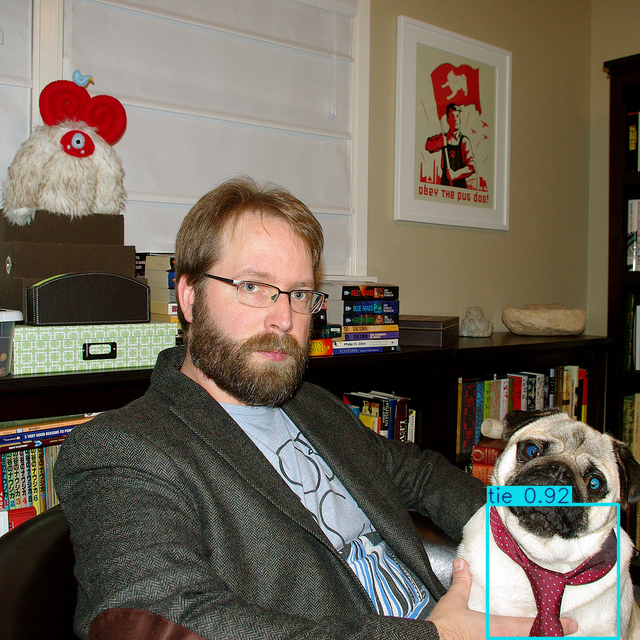

In [ ]:
test_image = val_imgs[15]
print("Realizando inferência na imagem:", test_image)
results = model(test_image)
results[0].show()
